<a href="https://colab.research.google.com/github/prabsshrestha/GithubHost/blob/master/TextToImage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install big-sleep --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 5.4 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116933 sha256=53630afc5bdf7bc1259e70aedc5097cf00f1049bf1166f5afcb756f0813f8c17
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.10
    Uninstalling wcwidth-0.2.10:
   

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import pickle
import random
import time

import PIL
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from keras import Input, Model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.layers import Dense, LeakyReLU, BatchNormalization, ReLU, Reshape, UpSampling2D, Conv2D, Activation, \
    concatenate, Flatten, Lambda, Concatenate
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input


In [ ]:
def load_class_ids(class_info_file_path):
    """
    Load class ids from class_info.pickle file
    """
    with open(class_info_file_path, 'rb') as f:
        class_ids = pickle.load(f, encoding='latin1')
        return class_ids

def load_embeddings(embeddings_file_path):
    """
    Load embeddings
    """
    with open(embeddings_file_path, 'rb') as f:
        embeddings = pickle.load(f, encoding='latin1')
        embeddings = np.array(embeddings)
        print('embeddings: ', embeddings.shape)
    return embeddings

def load_filenames(filenames_file_path):
    """
    Load filenames.pickle file and return a list of all file names
    """
    with open(filenames_file_path, 'rb') as f:
        filenames = pickle.load(f, encoding='latin1')
    return filenames

def load_bounding_boxes(dataset_dir):
    """
    Load bounding boxes and return a dictionary of file names and corresponding bounding boxes
    """
    # Paths
    bounding_boxes_path = os.path.join(dataset_dir, 'bounding_boxes.txt')
    file_paths_path = os.path.join(dataset_dir, 'images.txt')

    # Read bounding_boxes.txt and images.txt file
    df_bounding_boxes = pd.read_csv(bounding_boxes_path,
                                    delim_whitespace=True, header=None).astype(int)
    df_file_names = pd.read_csv(file_paths_path, delim_whitespace=True, header=None)

    # Create a list of file names
    file_names = df_file_names[1].tolist()

    # Create a dictionary of file_names and bounding boxes
    filename_boundingbox_dict = {img_file[:-4]: [] for img_file in file_names[:2]}

    # Assign a bounding box to the corresponding image
    for i in range(0, len(file_names)):
        # Get the bounding box
        bounding_box = df_bounding_boxes.iloc[i][1:].tolist()
        key = file_names[i][:-4]
        filename_boundingbox_dict[key] = bounding_box

    return filename_boundingbox_dict

def get_img(img_path, bbox, image_size):
    """
    Load and resize image
    """
    img = Image.open(img_path).convert('RGB')
    width, height = img.size
    if bbox is not None:
        R = int(np.maximum(bbox[2], bbox[3]) * 0.75)
        center_x = int((2 * bbox[0] + bbox[2]) / 2)
        center_y = int((2 * bbox[1] + bbox[3]) / 2)
        y1 = np.maximum(0, center_y - R)
        y2 = np.minimum(height, center_y + R)
        x1 = np.maximum(0, center_x - R)
        x2 = np.minimum(width, center_x + R)
        img = img.crop([x1, y1, x2, y2])
    img = img.resize(image_size, PIL.Image.BILINEAR)
    return img

def load_dataset(filenames_file_path, class_info_file_path, cub_dataset_dir, embeddings_file_path, image_size):
    """
    Load dataset
    """
    filenames = load_filenames(filenames_file_path)
    class_ids = load_class_ids(class_info_file_path)
    bounding_boxes = load_bounding_boxes(cub_dataset_dir)
    all_embeddings = load_embeddings(embeddings_file_path)

    X, y, embeddings = [], [], []

    print("Embeddings shape:", all_embeddings.shape)

    for index, filename in enumerate(filenames):
        bounding_box = bounding_boxes[filename]

        try:
            # Load images
            img_name = '{}/images/{}.jpg'.format(cub_dataset_dir, filename)
            img = get_img(img_name, bounding_box, image_size)

            all_embeddings1 = all_embeddings[index, :, :]

            embedding_ix = random.randint(0, all_embeddings1.shape[0] - 1)
            embedding = all_embeddings1[embedding_ix, :]

            X.append(np.array(img))
            y.append(class_ids[index])
            embeddings.append(embedding)
        except Exception as e:
            print(e)

    X = np.array(X)
    y = np.array(y)
    embeddings = np.array(embeddings)
    return X, y, embeddings


In [ ]:
def generate_c(x):
    mean = x[:, :128]
    log_sigma = x[:, 128:]
    stddev = K.exp(log_sigma)
    epsilon = K.random_normal(shape=K.constant((mean.shape[1],), dtype='int32'))
    c = stddev * epsilon + mean
    return c

def build_ca_model():
    """
    Get conditioning augmentation model.
    Takes an embedding of shape (1024,) and returns a tensor of shape (256,)
    """
    input_layer = Input(shape=(1024,))
    x = Dense(256)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
    model = Model(inputs=[input_layer], outputs=[x])
    return model

def build_embedding_compressor_model():
    """
    Build embedding compressor model
    """
    input_layer = Input(shape=(1024,))
    x = Dense(128)(input_layer)
    x = ReLU()(x)

    model = Model(inputs=[input_layer], outputs=[x])
    return model

def build_stage1_generator():
    """
    Builds a generator model used in Stage-I
    """
    input_layer = Input(shape=(1024,))
    x = Dense(256)(input_layer)
    mean_logsigma = LeakyReLU(alpha=0.2)(x)

    c = Lambda(generate_c)(mean_logsigma)

    input_layer2 = Input(shape=(100,))

    gen_input = Concatenate(axis=1)([c, input_layer2])

    x = Dense(128 * 8 * 4 * 4, use_bias=False)(gen_input)
    x = ReLU()(x)

    x = Reshape((4, 4, 128 * 8), input_shape=(128 * 8 * 4 * 4,))(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(512, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(3, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = Activation(activation='tanh')(x)

    stage1_gen = Model(inputs=[input_layer, input_layer2], outputs=[x, mean_logsigma])
    return stage1_gen

def build_stage1_discriminator():
    """
    Create a model which takes two inputs
    1. One from above network
    2. One from the embedding layer
    3. Concatenate along the axis dimension and feed it to the last module which produces final logits
    """
    input_layer = Input(shape=(64, 64, 3))

    x = Conv2D(64, (4, 4),
               padding='same', strides=2,
               input_shape=(64, 64, 3), use_bias=False)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    input_layer2 = Input(shape=(4, 4, 128))

    merged_input = concatenate([x, input_layer2])

    x2 = Conv2D(64 * 8, kernel_size=1,
                padding="same", strides=1)(merged_input)
    x2 = BatchNormalization()(x2)
    x2 = LeakyReLU(alpha=0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(1)(x2)
    x2 = Activation('sigmoid')(x2)

    stage1_dis = Model(inputs=[input_layer, input_layer2], outputs=[x2])
    return stage1_dis

def build_adversarial_model(gen_model, dis_model):
    input_layer = Input(shape=(1024,))
    input_layer2 = Input(shape=(100,))
    input_layer3 = Input(shape=(4, 4, 128))

    x, mean_logsigma = gen_model([input_layer, input_layer2])

    dis_model.trainable = False
    valid = dis_model([x, input_layer3])

    model = Model(inputs=[input_layer, input_layer2, input_layer3], outputs=[valid, mean_logsigma])
    return model


In [ ]:
def KL_loss(y_true, y_pred):
    mean = y_pred[:, :128]
    logsigma = y_pred[:, 128:]
    loss = -0.5 * K.sum(1 + 2 * logsigma - K.square(mean) - K.exp(2 * logsigma), axis=-1)
    return K.mean(loss)



def custom_generator_loss(y_true, y_pred):
    # Calculate binary cross entropy loss
    return K.binary_crossentropy(y_true, y_pred)

In [ ]:
def save_rgb_img(img, path):
    """
    Save an rgb image
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Image")

    plt.savefig(path)
    plt.close()

def write_log(callback, name, loss, batch_no):

 writer = tf.summary.create_file_writer("/content/gdrive/MyDrive/Major Project/birds implementation/logs")
 with writer.as_default():
  for step in range(100):
    # other model code would go here
    tf.summary.scalar("my_metric", 0.5, step=step)
    writer.flush()

In [ ]:
if __name__ == '__main__':
    data_dir = "/content/gdrive/MyDrive/Major Project/birds implementation/birds"
    train_dir = data_dir + "/train"
    test_dir = data_dir + "/test"
    image_size = 64
    batch_size = 64
    z_dim = 100
    stage1_generator_lr = 0.0002
    stage1_discriminator_lr = 0.0002
    stage1_lr_decay_step = 600
    epochs = 1000
    condition_dim = 128

    embeddings_file_path_train = train_dir + "/char-CNN-RNN-embeddings.pickle"
    embeddings_file_path_test = test_dir + "/char-CNN-RNN-embeddings.pickle"

    filenames_file_path_train = train_dir + "/filenames.pickle"
    filenames_file_path_test = test_dir + "/filenames.pickle"

    class_info_file_path_train = train_dir + "/class_info.pickle"
    class_info_file_path_test = test_dir + "/class_info.pickle"

    cub_dataset_dir = "/content/gdrive/MyDrive/Major Project/birds implementation/CUB_200_2011"

    # Define optimizers
    dis_optimizer = Adam(learning_rate=stage1_discriminator_lr, beta_1=0.5, beta_2=0.999)
    gen_optimizer = Adam(learning_rate=stage1_generator_lr, beta_1=0.5, beta_2=0.999)

    """"
    Load datasets
    """
    X_train, y_train, embeddings_train = load_dataset(filenames_file_path=filenames_file_path_train,
                                                      class_info_file_path=class_info_file_path_train,
                                                      cub_dataset_dir=cub_dataset_dir,
                                                      embeddings_file_path=embeddings_file_path_train,
                                                      image_size=(64, 64))

    X_test, y_test, embeddings_test = load_dataset(filenames_file_path=filenames_file_path_test,
                                                   class_info_file_path=class_info_file_path_test,
                                                   cub_dataset_dir=cub_dataset_dir,
                                                   embeddings_file_path=embeddings_file_path_test,
                                                   image_size=(64, 64))

    """
    Build and compile networks
    """
    ca_model = build_ca_model()
    ca_model.compile(loss="binary_crossentropy", optimizer="adam")

    stage1_dis = build_stage1_discriminator()
    stage1_dis.compile(loss='binary_crossentropy', optimizer=dis_optimizer)

    stage1_gen = build_stage1_generator()
    stage1_gen.compile(loss="mse", optimizer=gen_optimizer)

    embedding_compressor_model = build_embedding_compressor_model()
    embedding_compressor_model.compile(loss="binary_crossentropy", optimizer="adam")

    adversarial_model = build_adversarial_model(gen_model=stage1_gen, dis_model=stage1_dis)
    adversarial_model.compile(loss=['binary_crossentropy', KL_loss], loss_weights=[1, 2.0],
                              optimizer=gen_optimizer, metrics=None)

    tensorboard = TensorBoard(log_dir="/content/gdrive/MyDrive/Major Project/birds implementation/logs".format(time.time()))
    tensorboard.set_model(stage1_gen)
    tensorboard.set_model(stage1_dis)
    tensorboard.set_model(ca_model)
    tensorboard.set_model(embedding_compressor_model)

    # Generate an array containing real and fake values
    # Apply label smoothing as well
    real_labels = np.ones((batch_size, 1), dtype=float) * 0.9
    fake_labels = np.zeros((batch_size, 1), dtype=float) * 0.1

    for epoch in range(epochs):
        print("========================================")
        print("Epoch is:", epoch)
        print("Number of batches", int(X_train.shape[0] / batch_size))

        gen_losses = []
        dis_losses = []

        # Load data and train model
        number_of_batches = int(X_train.shape[0] / batch_size)
        for index in range(number_of_batches):
            print("Batch:{}".format(index+1))

            """
            Train the discriminator network
            """
            # Sample a batch of data
            z_noise = np.random.normal(0, 1, size=(batch_size, z_dim))
            image_batch = X_train[index * batch_size:(index + 1) * batch_size]
            embedding_batch = embeddings_train[index * batch_size:(index + 1) * batch_size]
            image_batch = (image_batch - 127.5) / 127.5

            # Generate fake images
            fake_images, _ = stage1_gen.predict([embedding_batch, z_noise], verbose=3)

            # Generate compressed embeddings
            compressed_embedding = embedding_compressor_model.predict_on_batch(embedding_batch)
            compressed_embedding = np.reshape(compressed_embedding, (-1, 1, 1, condition_dim))
            compressed_embedding = np.tile(compressed_embedding, (1, 4, 4, 1))

            dis_loss_real = stage1_dis.train_on_batch([image_batch, compressed_embedding],
                                                      np.reshape(real_labels, (batch_size, 1)))
            dis_loss_fake = stage1_dis.train_on_batch([fake_images, compressed_embedding],
                                                      np.reshape(fake_labels, (batch_size, 1)))
            dis_loss_wrong = stage1_dis.train_on_batch([image_batch[:(batch_size - 1)], compressed_embedding[1:]],
                                                       np.reshape(fake_labels[1:], (batch_size-1, 1)))

            d_loss = 0.5 * np.add(dis_loss_real, 0.5 * np.add(dis_loss_wrong, dis_loss_fake))

            print("d_loss_real:{}".format(dis_loss_real))
            print("d_loss_fake:{}".format(dis_loss_fake))
            print("d_loss_wrong:{}".format(dis_loss_wrong))
            print("d_loss:{}".format(d_loss))

            """
            Train the generator network
            """
            g_loss = adversarial_model.train_on_batch([embedding_batch, z_noise, compressed_embedding],[K.ones((batch_size, 1)) * 0.9, K.ones((batch_size, 256)) * 0.9])
            print("g_loss:{}".format(g_loss))

            dis_losses.append(d_loss)
            gen_losses.append(g_loss)


        '''Save losses to Tensorboard after each epoch'''

        write_log(tensorboard, 'discriminator_loss', np.mean(dis_losses), epoch)
        write_log(tensorboard, 'generator_loss', np.mean(gen_losses[0]), epoch)

        # Generate and save images after every 2nd epoch
        if epoch % 2 == 0:
            # z_noise2 = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            z_noise2 = np.random.normal(0, 1, size=(batch_size, z_dim))
            embedding_batch = embeddings_test[0:batch_size]
            fake_images, _ = stage1_gen.predict_on_batch([embedding_batch, z_noise2])

            # Save images
            for i, img in enumerate(fake_images[:10]):
                save_rgb_img(img, "/content/gdrive/MyDrive/Major Project/birds implementation/results/gen_{}_{}.png".format(epoch, i))




    # Save models
    stage1_gen.save_weights("stage1_gen.h5")
    stage1_dis.save_weights("stage1_dis.h5")

embeddings:  (8855, 10, 1024)
Embeddings shape: (8855, 10, 1024)


KeyboardInterrupt: ignored

In [ ]:
def inception_score(fake_images):
    # Load the InceptionV3 model without the top fully connected layers
    model = InceptionV3(include_top=False, pooling='avg')

    # Preprocess the generated images
    fake_images = preprocess_input(fake_images)

    # Obtain the predicted class probabilities for each image
    predictions = model.predict(fake_images)

    # Remove the zeros from the predictions array
    nonzero_indices = np.nonzero(predictions)
    predictions = predictions[nonzero_indices]
    print("Pred:",predictions)
    # Calculate the KL divergence between each image's predicted class probabilities
    # and the uniform distribution
    kl_divergences = np.mean(np.sum(np.log(predictions) * predictions))

    # Return the exponential of the average KL divergence
    return np.exp(kl_divergences)

In [ ]:
#cell for calculating Inception Score:
import torch
import glob
import os
import numpy as np
import torchvision.transforms as transforms

transform = transforms.Compose([    transforms.Resize((299, 299)),    transforms.ToTensor(),    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])

folder_path = "/content/gdrive/MyDrive/Major Project/birds implementation/results"
"""folder_path = ["/content/gdrive/MyDrive/Major Project/birds implementation/CUB_200_2011/images/001.Black_footed_Albatross","/content/gdrive/MyDrive/Major Project/birds implementation/CUB_200_2011/images/002.Laysan_Albatross","/content/gdrive/MyDrive/Major Project/birds implementation/CUB_200_2011/images/003.Sooty_Albatross","/content/gdrive/MyDrive/Major Project/birds implementation/CUB_200_2011/images/006.Least_Auklet"]"""
image_paths = glob.glob(os.path.join(folder_path, "*.png"))

"""image_paths = [ "/content/gdrive/MyDrive/Major Project/birds implementation/results/gen_54_6.png",                 "/content/gdrive/MyDrive/Major Project/birds implementation/results/gen_204_5.png",                 "/content/gdrive/MyDrive/Major Project/birds implementation/results/gen_104_6.png" ]"""

images = []
for image_path in image_paths:
    image = Image.open(image_path)
    image = image.convert('RGB')
    image = transform(image)
    images.append(image)


# Concatenate the PyTorch tensors into a single tensor
images = torch.stack(images)

# Convert the PyTorch tensor to a numpy array
fake_images = images.detach().numpy()
fake_images = np.array(images)
fake_images = np.transpose(fake_images, (0, 2, 3, 1))
# Calculate the inception score
incept_score = calculate_inception_score(fake_images)
print("Inception Score:", incept_score)

42/42 [==============================] - 15s 140ms/step
Inception Score: 1.1038721


In [ ]:
# example of calculating the frechet inception distance in Keras
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
import torch
import glob
import os
import numpy as np
import torchvision.transforms as transforms

transform = transforms.Compose([    transforms.Resize((299, 299)),    transforms.ToTensor(),    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])

folder_path = "/content/gdrive/MyDrive/Major Project/birds implementation/results"
"""folder_path = ["/content/gdrive/MyDrive/Major Project/birds implementation/CUB_200_2011/images/001.Black_footed_Albatross","/content/gdrive/MyDrive/Major Project/birds implementation/CUB_200_2011/images/002.Laysan_Albatross","/content/gdrive/MyDrive/Major Project/birds implementation/CUB_200_2011/images/003.Sooty_Albatross","/content/gdrive/MyDrive/Major Project/birds implementation/CUB_200_2011/images/006.Least_Auklet"]"""
image_paths = glob.glob(os.path.join(folder_path, "*.png"))

"""image_paths = [ "/content/gdrive/MyDrive/Major Project/birds implementation/results/gen_54_6.png",                 "/content/gdrive/MyDrive/Major Project/birds implementation/results/gen_204_5.png",                 "/content/gdrive/MyDrive/Major Project/birds implementation/results/gen_104_6.png" ]"""

images = []
for image_path in image_paths:
    image = Image.open(image_path)
    image = image.convert('RGB')
    image = transform(image)
    images.append(image)


# Concatenate the PyTorch tensors into a single tensor
images = torch.stack(images)


# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
# define two fake collections of images
images1 = randint(0, 255, 10*32*32*3)
images1 = images1.reshape((10,32,32,3))
images2 = randint(0, 255, 10*32*32*3)
images2 = images2.reshape((10,32,32,3))
print('Prepared', images1.shape, images2.shape)
# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)
# fid between images1 and images1
fid = calculate_fid(model, images1, images1)
print('FID (same): %.3f' % fid)
# fid between images1 and images2
fid = calculate_fid(model, images1, images2)
print('FID (different): %.3f' % fid)

87910968/87910968 [==============================] - 3s 0us/step
Prepared (10, 32, 32, 3) (10, 32, 32, 3)
Scaled (10, 299, 299, 3) (10, 299, 299, 3)
1/1 [==============================] - 0s 35ms/step
FID (same): -0.000
1/1 [==============================] - 0s 56ms/step
FID (different): 39.304


In [ ]:
!pip install numpy
!pip install tensorflow
!pip install keras
!pip install Pillow
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from math import floor
from numpy import ones
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

# assumes images have the shape 299x299x3, pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
 # load inception v3 model
 model = InceptionV3()
 # convert from uint8 to float32
 processed = images.astype('float32')
 # pre-process raw images for inception v3 model
 processed = preprocess_input(processed)
 # predict class probabilities for images
 yhat = model.predict(processed)
 # enumerate splits of images/predictions
 scores = list()
 n_part = floor(images.shape[0] / n_split)
 for i in range(n_split):
   # retrieve p(y|x)
  ix_start, ix_end = i * n_part, i * n_part + n_part
  p_yx = yhat[ix_start:ix_end]
  # calculate p(y)
  p_y = expand_dims(p_yx.mean(axis=0), 0)
  # calculate KL divergence using log probabilities
  kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
  # sum over classes
  sum_kl_d = kl_d.sum(axis=1)
 # average over images
 avg_kl_d = mean(sum_kl_d)
 # undo the log
 is_score = exp(avg_kl_d)
 # store
 scores.append(is_score)
 # average across images
 is_avg, is_std = mean(scores), std(scores)
 return is_avg



setting seed of 0
you can override this with --seed argument in the command line, or --random for a randomly chosen one


100%|███████████████████████████████████████| 354M/354M [00:04<00:00, 86.8MiB/s]
100%|██████████| 800/800 [00:00<00:00, 967265.26B/s]


epochs:   0%|          | 0/20 [00:00<?, ?it/s]

iteration:   0%|          | 0/1000 [00:00<?, ?it/s]

image updated at "./a_lion_walking_in_snow.png"


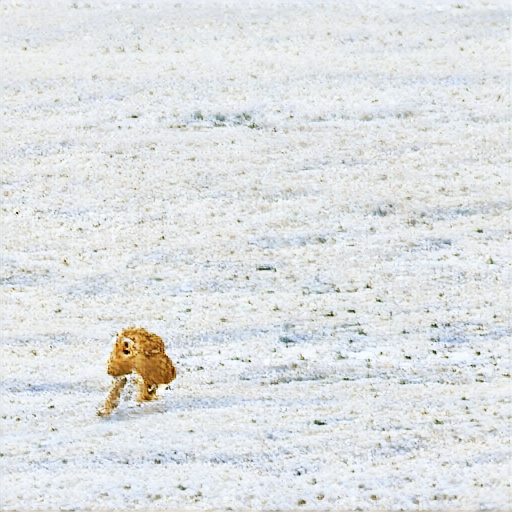

image updated at "./a_lion_walking_in_snow.png"


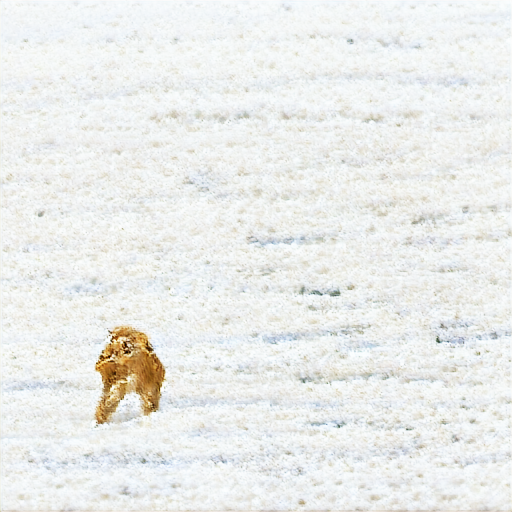

image updated at "./a_lion_walking_in_snow.png"


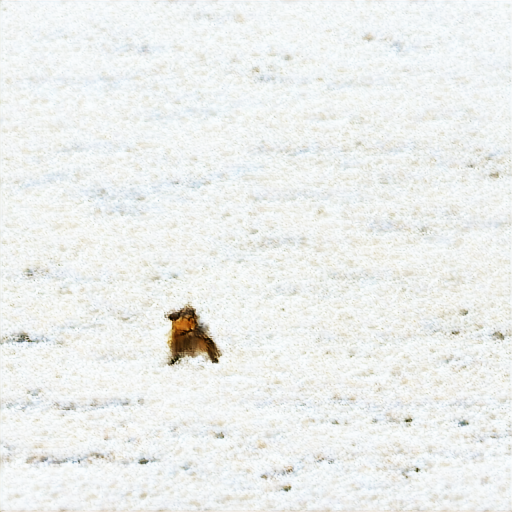

image updated at "./a_lion_walking_in_snow.png"


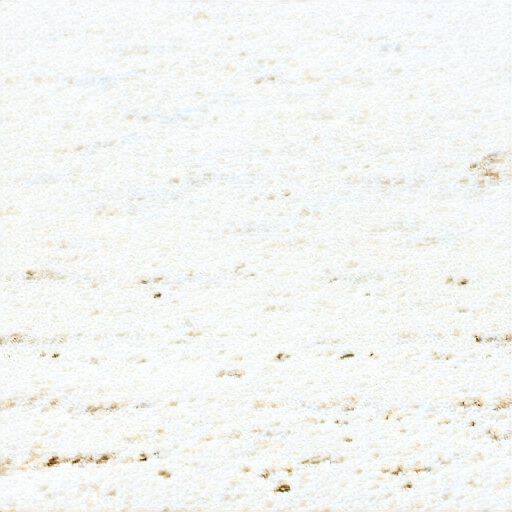

image updated at "./a_lion_walking_in_snow.png"


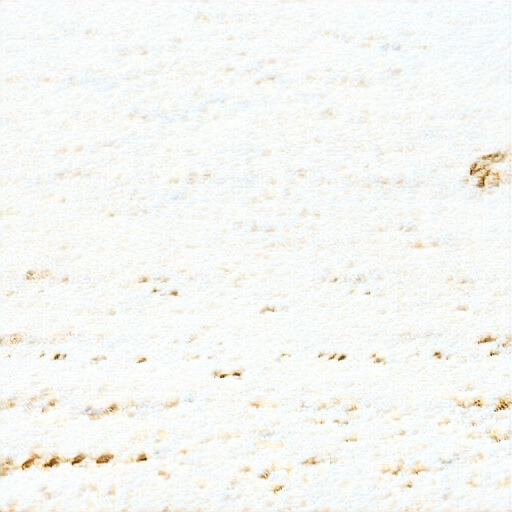

image updated at "./a_lion_walking_in_snow.png"


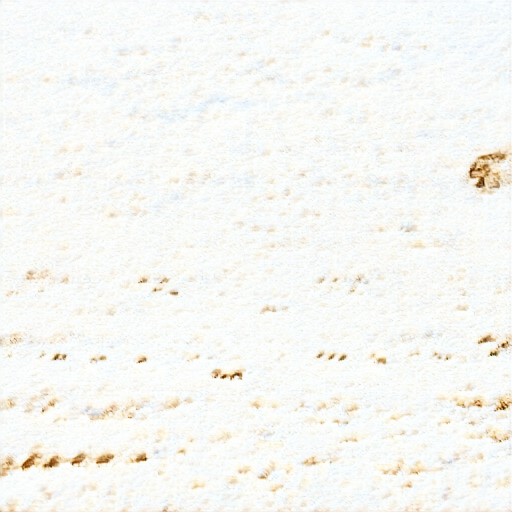

image updated at "./a_lion_walking_in_snow.png"


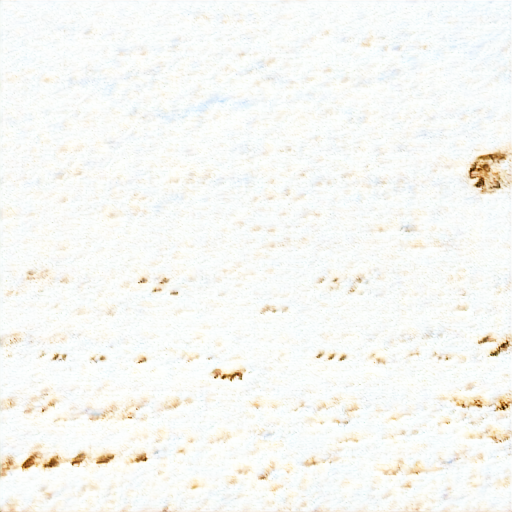

image updated at "./a_lion_walking_in_snow.png"


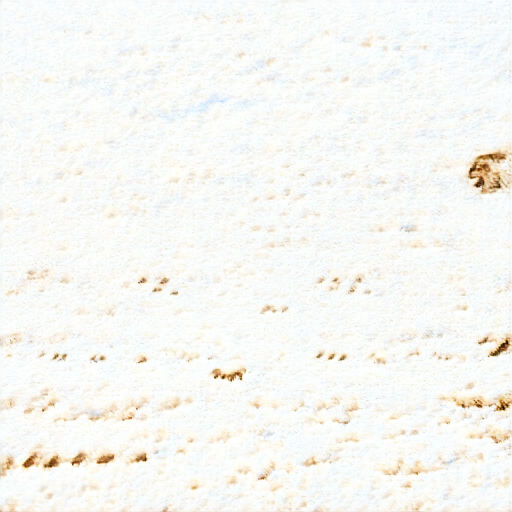

In [ ]:
from tqdm.notebook import trange
from IPython.display import Image, display

from big_sleep import Imagine

TEXT = 'a lion walking in snow' #@param {type:"string"}
SAVE_EVERY = 100 #@param {type:"number"}
SAVE_PROGRESS = True #@param {type:"boolean"}
LEARNING_RATE = 5e-2 #@param {type:"number"}
ITERATIONS = 1050 #@param {type:"number"}
SEED = 0 #@param {type: "number"}

model = Imagine(
    text = TEXT,
    save_every = SAVE_EVERY,
    lr = LEARNING_RATE,
    iterations = ITERATIONS,
    save_progress = SAVE_PROGRESS,
    seed = SEED
)

for epoch in trange(20, desc = 'epochs'):
    for i in trange(1000, desc = 'iteration'):
        model.train_step(epoch, i)

        if i == 0 or i % model.save_every != 0:
            continue

        filename = TEXT.replace(' ', '_')
        image = Image(f'./{filename}.png')
        display(image)